In [1]:
from sklearn.model_selection import train_test_split #para dividir sets de entrenamiendo y prueba

import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir 
import pandas as pd

from skimage.filters import gaussian  #filtro para la deteccion de bordes
from skimage.filters import sobel  #filtro para la deteccion de bordes
from skimage.filters import unsharp_mask  #filtro para la deteccion de bordes


from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
import argparse

from sklearn.metrics import roc_curve, RocCurveDisplay, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay

(256, 256, 3)


C:\Users\felli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


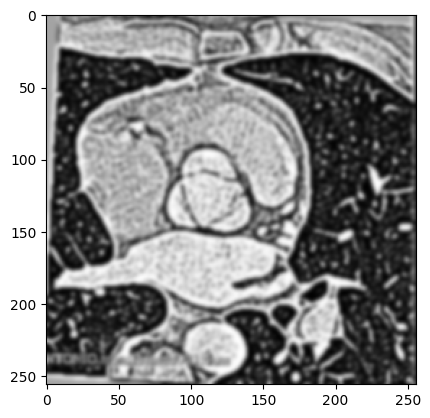

In [2]:
'''
PRIMERA CAPA DE PREPROCESAMIENTO
    1) QUITAR EL FONDO NEGRO DE LA IMAGEN (RECORTE)
    2) AJUSTAR EL TAMANO DE LA IMAGEN (RESIZE)
'''

images = []

for filename in listdir('data'):
    #img=img_as_float(io.imread(f'data/{filename}'))
    img = cv2.imread(f'data/{filename}')
    img = img[:, 174:550] #recorte de imagen
    img = cv2.resize(img, [256,256])    

    
    img = cv2.convertScaleAbs(img, alpha=1.1, beta=1)  #alpha contrast   - beta = brightness
    img = unsharp_mask(img, radius=1, amount=50)
    img = gaussian(img, sigma=(1.5,1.5), truncate=3.5, channel_axis=2)


    images.append(img)

print(images[0].shape)
plt.imshow(images[0], cmap='binary', vmin=0, vmax=255)

In [9]:
def gen_superpixels(image, numSegments = 110, sigma=3.5): 
    image_superpixels  = slic(image, n_segments = numSegments, sigma = sigma)
    return image_superpixels

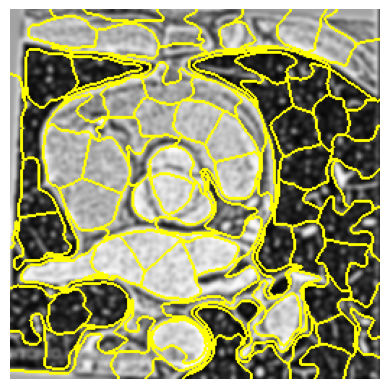

In [8]:
numSegments = 110
segments = slic(images[0], n_segments = numSegments, sigma = 3.5)

# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (numSegments))
ax = fig.add_subplot(1, 1, 1)

superpixels_image = mark_boundaries(images[0], segments)
ax.imshow(superpixels_image)
plt.axis("off")
# show the plots
plt.show()

In [10]:
superpixels_images = [] 

for img in images :
    sp = gen_superpixels(img)
    superpixels_images.append(sp)

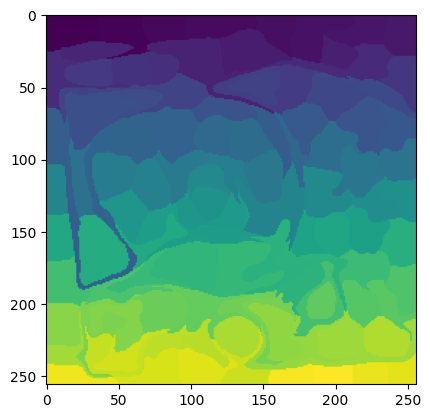

In [12]:
superpixels_image = mark_boundaries(images[0], segments)
ax.imshow(superpixels_image)
plt.axis("off")
# show the plots
plt.show()

In [5]:
#def get_label(x,y, labels):
#    return labels[y,x]
#
#coords=[]
#def click_event(event, x, y, flags, params):
#
#    # checking for left mouse clicks
#    if event == cv2.EVENT_LBUTTONDOWN:
#
#        # displaying the coordinates
#        # on the Shell
#        print(x, ' ', y)
#
#        # displaying the coordinates
#        # on the image window
#        font = cv2.FONT_HERSHEY_SIMPLEX
#        cv2.putText(superpixels_image, str(x) + ',' +
#                    str(y), (x, y), font,
#                    0.3, (0, 255, 0), 1)
#        cv2.imshow('image', superpixels_image)
#
#    # checking for right mouse clicks
#    if event == cv2.EVENT_RBUTTONDOWN:
#
#        # displaying the coordinates
#        # on the Shell
#        print(x, ' ', y)
#
#        # displaying the coordinates
#        # on the image window
#        font = cv2.FONT_HERSHEY_SIMPLEX
#        cv2.putText(superpixels_image, str(get_label(x,y,segments)),
#                    (x, y), font, 0.3,
#                    (255, 0, 255), 1)
#        cv2.imshow('image', superpixels_image)
#        coords.append([x,y])
#    
#

In [6]:
#cv2.imshow('image', superpixels_image)
#
## setting mouse handler for the image
## and calling the click_event() function
#
#cv2.setMouseCallback('image', click_event)
#
## wait for a key to be pressed to exit
#cv2.waitKey(0)
#
## close the window
#cv2.destroyAllWindows()

109   129
109   109
93   136
125   141
169   140


In [7]:
mask = np.zeros(images[0].shape[:2], dtype = "uint8")

for x,y in coords: 
    mask[segments == get_label(x,y, segments)] = 255

masked_image = cv2.bitwise_or(images[0], images[0], mask = mask)
cv2.imshow("Applied",masked_image)
cv2.waitKey(0)

-1